Focus on the images first

In [1]:
# import the needed libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.io
import cv2
import tensorflow as tf
import random
from skimage.transform import resize
from scipy import ndimage

In [2]:


# Get the path for the data

path_unfiltered_train = r"C:\Users\15739\Desktop\UNL - all\Summer 2022\Manuscript\Image_set_1\unfiltered_train"

In [3]:
# get the names of the images
all_images = os.listdir(path_unfiltered_train)

In [4]:
# sanity check
len(all_images)

163

In [5]:
# join the path and the image name for each image
image_paths = []
for image in all_images:
    img_path = os.path.join(path_unfiltered_train, image)
    image_paths.append(img_path)

In [6]:
len(image_paths)

163

In [7]:
# store the images as numpy arrays

# specify the folder
store_path = r'C:\Users\15739\Desktop\UNL - all\Summer 2022\Manuscript\Image_set_1\numpy train data'

In [8]:
# now for each image in image_paths, save it as a numpy array
# need to keep track of image size to generate the densities
image_size = []
for i in image_paths:
#     read the image
    read_image = plt.imread(i)
# size of the image
    img_shape = read_image.shape
#     append the shapes of the resized images
    image_size.append(img_shape)
#     get image name
    image_name = (i.split("\\")[-1]).split(".")[0]
#     store the image as numpy array
    np.save(store_path + "\\"+ image_name + "_resized.npy", read_image)
    

Now consider the locations of the tassels

In [9]:
# import the csv file with the locations of the tassels
tassel_coords = pd.read_csv(r"C:\Users\15739\Desktop\UNL - all\Summer 2022\Manuscript\Image_set_1\new_annotated_coordinates_all.csv", header = None) 

# renname the columns as they aren't named
tassel_coords.columns = ['Image Name', 'top_x', 'top_y', 'width', 'height']

# have a look at the data
tassel_coords.head()

,Image Name,top_x,top_y,width,height
0,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,42,45,61,40
1,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,40,84,65,41
2,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,34,119,76,36
3,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,71,430,45,50
4,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,59,614,35,46


In [10]:
# how many unique image information?
len(tassel_coords["Image Name"].unique())

323

In [11]:
# Now, need to extract the coordinates per each image, 
# and then do the preprocessing so that the density maps can be arrived at

# for getting the coordinates per image, we need to subset the dataframe by the image
# and store the coordinates in a list

# define a function for this
def extract_midcoords(image_name):
# get the corrdinates corresponding to image
    coords = tassel_coords[(tassel_coords["Image Name"] == 
                        image_name)].reset_index(drop = True)

# extract only the 4 columns of coordinates
    coords_only = coords[['top_x', 'top_y', 'width', 'height']]

# deduct  from all cells (as instructed due to matlab indexing)
    coords_only = coords_only - 1

# compute the centroids based on coords
    coords_only['mid_x'] = round((coords_only['top_x'] + (coords_only['top_x'] + coords_only['width']))/2).astype(int)
    coords_only['mid_y'] = round((coords_only['top_y'] + (coords_only['top_y'] + coords_only['height']))/2).astype(int)

# extract only the centroids as that is all we need
    mid_coords = coords_only[['mid_x', 'mid_y']]

# convert the dataframne of mid coordinates to a list
# convert these dataframe values to a list
    mid_coords_list = mid_coords.values.tolist()
    return(mid_coords_list)

In [12]:
# do this for all the images
all_centroids = []
for image in all_images:
    extracted_coords = extract_midcoords(image)
    all_centroids.append(extracted_coords)

In [13]:
# sanity check
len(all_centroids)




163

In [14]:
# check for random images if this is correct

# for 6th image in all images
len(all_centroids[0])


25

In [15]:
# sanity check ctd...

# name of this image
selected_image = all_images[0]

# get the coords
coords_selected_image = tassel_coords[(tassel_coords["Image Name"] == 
                        selected_image)].reset_index(drop = True)

# get the first dimension of the shape
coords_selected_image.shape[0]

25

In [16]:
image_size[0]

(1081, 263, 3)

In [17]:
# now need to create the density maps

# first create the empty maps
empty_image = []
for shape in image_size:
    np_image = np.zeros((shape[0], shape[1]))
    empty_image.append(np_image)

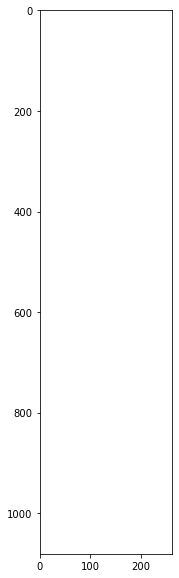

In [18]:
# visualize an empty map
dense_map = empty_image[0]

plt.figure(figsize = (10,10))
plt.imshow(dense_map, cmap = "Greys")
plt.show()

In [19]:
# get the dot maps
cat_image = []
for i, img in enumerate(empty_image):
    coords = all_centroids[i]
    for point in coords:
        img[point[1], point[0]] = 1
    cat_image.append(img)

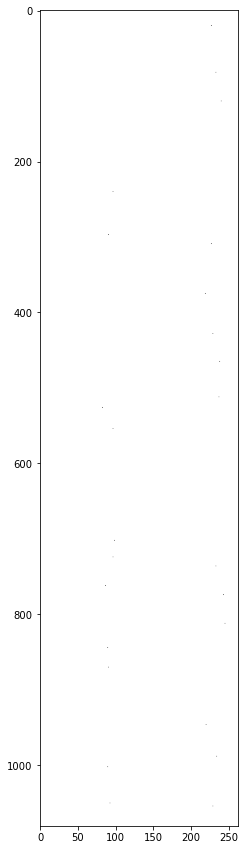

In [20]:
# draw the dot map for one image to see how ot looks like
dot_image = cat_image[0]

plt.figure(figsize = (15,15))
plt.imshow(dot_image, cmap = "Greys")
plt.show()

In [21]:
# now define the kernel and run the convolution
one_d_kerenel = cv2.getGaussianKernel(50,5)
two_d_kernel = np.multiply(one_d_kerenel.T, one_d_kerenel)

# Shape of teh 2D kernel
two_d_kernel.shape

(50, 50)

In [22]:
# now, convolve all the new blackened images

convolved_image = []
for image in cat_image:
    convolution = ndimage.convolve(image, two_d_kernel)
    convolved_image.append(convolution)

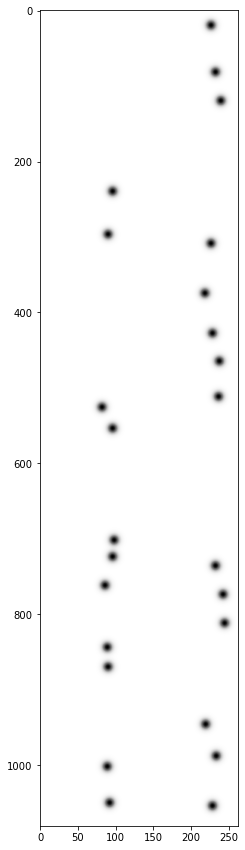

In [23]:
trial_image = convolved_image[0]

plt.figure(figsize = (15,15))
plt.imshow(trial_image, cmap = "Greys")
plt.show()

In [24]:
np.sum(convolved_image[0])

25.00008616149112

In [25]:
# check the length of the convolved images
len(convolved_image)

163

In [26]:
# now save all the density maps

for j, image in enumerate(convolved_image):
    mat_file_name = (all_images[j].split("\\")[-1]).split('.')[0]
    np.save(store_path + "\\"+ mat_file_name + "_densitymap.npy", image)

